## Naive bayes variations

Columns in dataset:
 ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_%3B', 'char_freq_%28', 'char_freq_%5B', 'char_freq_%21', 'char_fr

C:\Users\Kavi\AppData\Local\Temp\ipykernel_25340\204583935.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


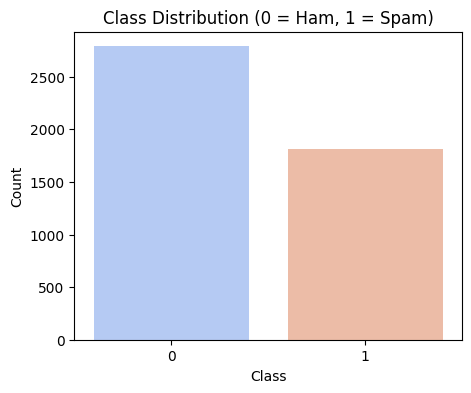

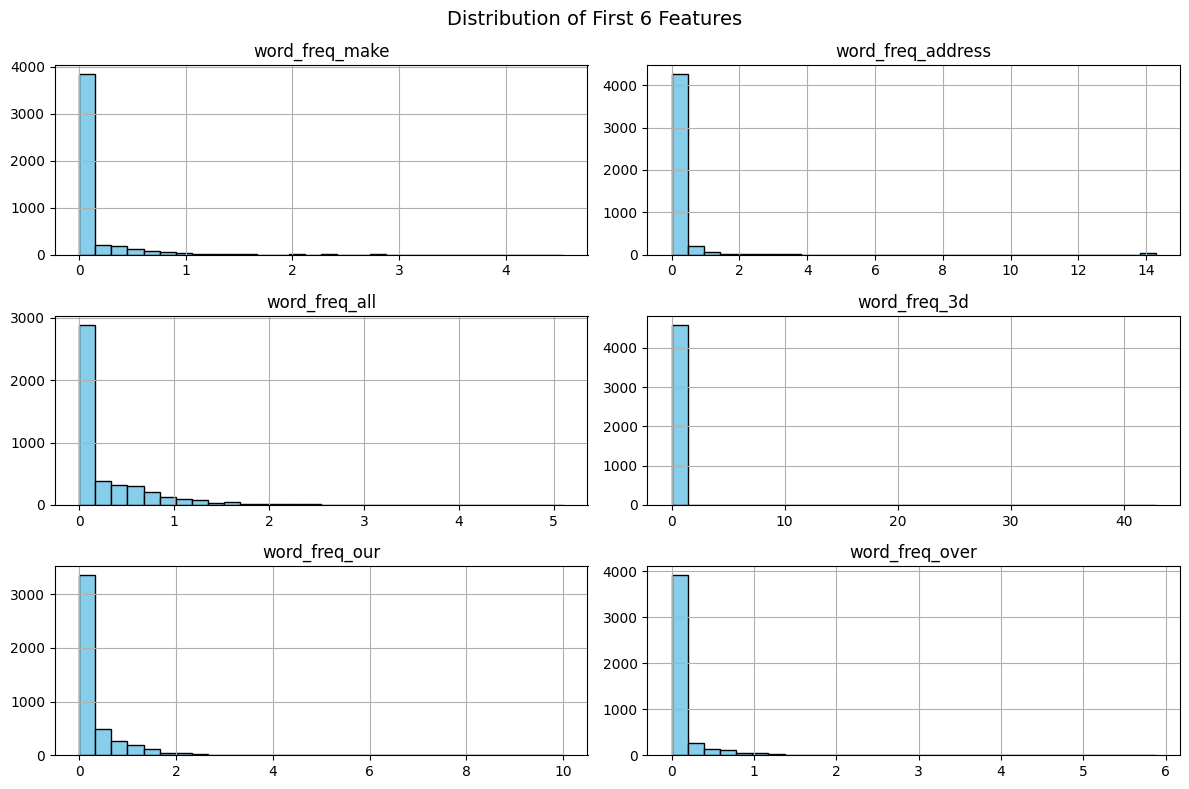

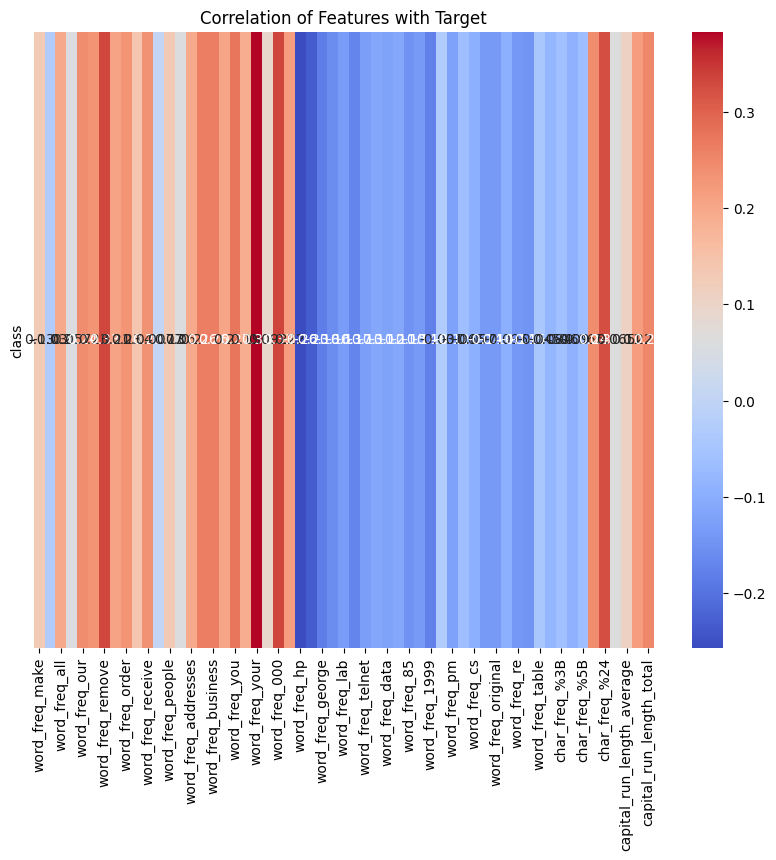

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from joblib import parallel_backend
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score, average_precision_score, accuracy_score, f1_score, precision_score, recall_score
)

# 1. Load Dataset
df = pd.read_csv('C:/Users/KAVI/Downloads/spambase_csv.csv')
print("Columns in dataset:\n", df.columns.tolist())
print("Dataset shape:", df.shape)

# 2. Separate features and target, last column is the target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]


# 4. EDA
plt.figure(figsize=(5,4))
sns.countplot(x=y, palette="coolwarm")
plt.title("Class Distribution (0 = Ham, 1 = Spam)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Histograms of first 6 features
X.iloc[:, :6].hist(bins=30, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of First 6 Features", fontsize=14)
plt.tight_layout()
plt.show()

# Correlation heatmap (optional, heavy if many features)
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr.iloc[-1:,:-1], annot=True, cmap="coolwarm")
plt.title("Correlation of Features with Target")
plt.show()

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [2]:
# Predict & Performance Analysis
def test_model(best_estimator, X_test,y_test):
    y_pred = best_estimator.predict(X_test)
    y_proba = best_estimator.predict_proba(X_test)[:, 1]
    return performance_metrics(y_test, y_pred, y_proba)

# Performance metrics
def performance_metrics(y_true, y_pred, y_proba):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)

    print("\nTest metrics")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Avg Precision (PR AUC-ish): {avg_precision:.4f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # 7. Curves: ROC & Precision-Recall
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--', alpha=0.5)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend(); plt.show()

# Define multiple metrics
def kfoldCV(best_estimator, X, y, cv):
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    # Run cross-validation
    with parallel_backend('threading'):
        cv_results = cross_validate(
            best_estimator, X, y, cv=cv,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1
        )

    n_splits = cv.get_n_splits()
    # Display per-fold results
    for i in range(n_splits):
        print(f"\nFold {i+1}: Accuracy: {cv_results['test_accuracy'][i]:.4f}   Precision: {cv_results['test_precision'][i]:.4f}   Recall: {cv_results['test_recall'][i]:.4f}   F1 Score: {cv_results['test_f1'][i]:.4f}")

    # Display averages
    print("\n=== Average Metrics ===")
    print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
    print(f"Mean Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
    print(f"Mean Recall:    {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
    print(f"Mean F1 Score:  {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .....................................clf__alpha=0.2; total time=   0.1s
[CV] END .....................................clf__alpha=0.3; total time=   0.1s
[CV] END .....................................clf__alpha=0.4; total time=   0.1s
[CV] END .....................................clf__alpha=0.3; total time=   0.1s
[CV] END .....................................clf__alpha=0.1; total time=   0.1s
[CV] END .....................................clf__alpha=0.2; total time=   0.1s
[CV] END .....................................clf__alpha=0.3; total time=   0.1s
[CV] END .....................................clf__alpha=0.1; total time=   0.1s
[CV] END .....................................clf__alpha=0.2; total time=   0.2s
[CV] END .....................................clf__alpha=0.3; total time=   0.2s
[CV] END .....................................clf__alpha=0.2; total time=   0.2s
[CV] END .....................................c

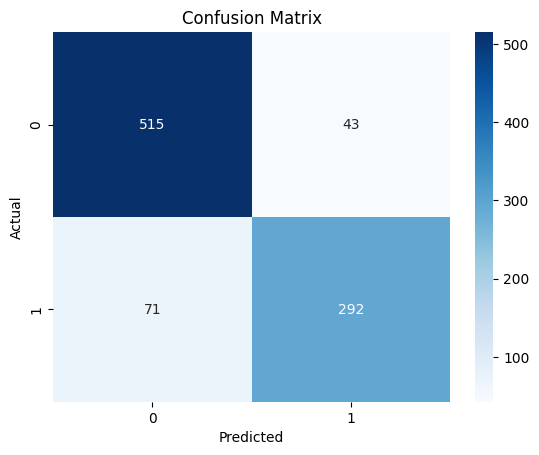

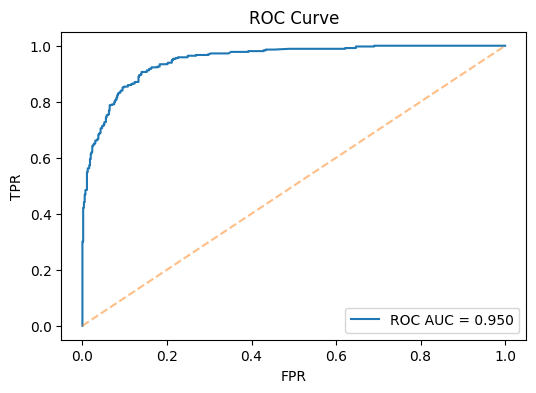


Fold 1: Accuracy: 0.8838   Precision: 0.8902   Recall: 0.8044   F1 Score: 0.8452

Fold 2: Accuracy: 0.8859   Precision: 0.8886   Recall: 0.8127   F1 Score: 0.8489

Fold 3: Accuracy: 0.8793   Precision: 0.8663   Recall: 0.8209   F1 Score: 0.8430

Fold 4: Accuracy: 0.9033   Precision: 0.9050   Recall: 0.8425   F1 Score: 0.8727

Fold 5: Accuracy: 0.8837   Precision: 0.8899   Recall: 0.8039   F1 Score: 0.8447

=== Average Metrics ===
Mean Accuracy: 0.8872 ± 0.0083
Mean Precision: 0.8880 ± 0.0124
Mean Recall:    0.8169 ± 0.0143
Mean F1 Score:  0.8509 ± 0.0111


C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


In [3]:
# Bernoulli Naive Bayes with Hyperparameter Tuning
pipeline = Pipeline([
    ('binarizer', Binarizer(threshold=0.0)),  # converts features to 0/1
    ('clf', BernoulliNB())
])

param_grid = {
    'clf__alpha': np.linspace(0.1, 2.0, 20)  # smoothing parameter
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring={'AUC': 'roc_auc', 'F1': 'f1'},
    refit='AUC',
    n_jobs=-1,
    verbose=2
)

with parallel_backend('threading'):
    grid.fit(X_train, y_train)
best = grid.best_estimator_


print("Best parameters:", grid.best_params_)
print("Best cross-validated AUC:", grid.best_score_)

# Test the decision tree model
best_estimator = grid.best_estimator_
test_model(best_estimator, X_test, y_test)
kfoldCV(best_estimator, X, y, cv)


C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .....................................clf__alpha=0.4; total time=   0.2s
[CV] END .....................................clf__alpha=0.3; total time=   0.2s
[CV] END .....................................clf__alpha=0.2; total time=   0.2s
[CV] END .....................................clf__alpha=0.3; total time=   0.3s
[CV] END .....................................clf__alpha=0.2; total time=   0.3s
[CV] END .....................................clf__alpha=0.1; total time=   0.3s
[CV] END .....................................clf__alpha=0.2; total time=   0.3s
[CV] END .....................................clf__alpha=0.3; total time=   0.3s
[CV] END .....................................clf__alpha=0.3; total time=   0.3s
[CV] END .....................................clf__alpha=0.1; total time=   0.3s
[CV] END .....................................clf__alpha=0.1; total time=   0.3s
[CV] END .....................................c

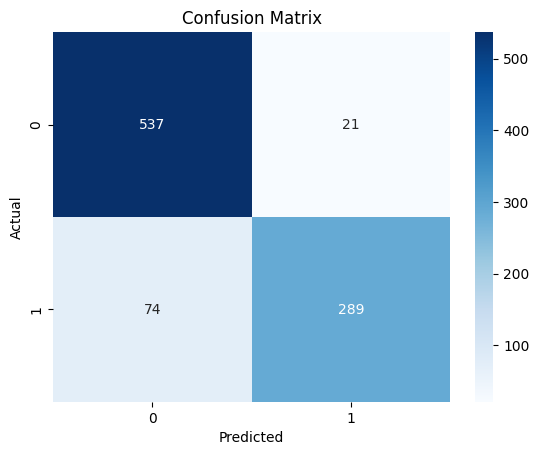

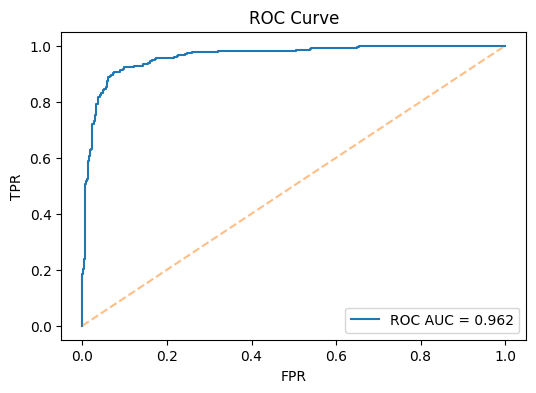


Fold 1: Accuracy: 0.8860   Precision: 0.9272   Recall: 0.7713   F1 Score: 0.8421

Fold 2: Accuracy: 0.8946   Precision: 0.9318   Recall: 0.7906   F1 Score: 0.8554

Fold 3: Accuracy: 0.8989   Precision: 0.9193   Recall: 0.8154   F1 Score: 0.8642

Fold 4: Accuracy: 0.8924   Precision: 0.9256   Recall: 0.7901   F1 Score: 0.8525

Fold 5: Accuracy: 0.8935   Precision: 0.9583   Recall: 0.7624   F1 Score: 0.8492

=== Average Metrics ===
Mean Accuracy: 0.8931 ± 0.0042
Mean Precision: 0.9324 ± 0.0136
Mean Recall:    0.7860 ± 0.0183
Mean F1 Score:  0.8527 ± 0.0073


C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
# Multinomial Naive Bayes with Hyperparameter Tuning
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', MultinomialNB())
])

param_grid = {
    'clf__alpha': np.linspace(0.1, 2.0, 20) 
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring={'AUC': 'roc_auc', 'F1': 'f1'},
    refit='AUC',
    n_jobs=-1,
    verbose=2
)

with parallel_backend('threading'):
    grid.fit(X_train, y_train)
best = grid.best_estimator_

print("Best parameters:", grid.best_params_)
print("Best cross-validated AUC:", grid.best_score_)

# Test the decision tree model
best_estimator = grid.best_estimator_
test_model(best_estimator, X_test, y_test)
kfoldCV(best_estimator, X, y, cv)

C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END clf__var_smoothing=1e-09, power__method=yeo-johnson; total time=   3.8s
[CV] END clf__var_smoothing=4.175318936560409e-09, power__method=yeo-johnson; total time=   3.8s
[CV] END clf__var_smoothing=4.175318936560409e-09, power__method=yeo-johnson; total time=   3.9s
[CV] END clf__var_smoothing=2.0433597178569395e-09, power__method=yeo-johnson; total time=   3.9s
[CV] END clf__var_smoothing=1e-09, power__method=yeo-johnson; total time=   3.9s
[CV] END clf__var_smoothing=4.175318936560409e-09, power__method=yeo-johnson; total time=   3.9s
[CV] END clf__var_smoothing=1e-09, power__method=yeo-johnson; total time=   3.9s
[CV] END clf__var_smoothing=1e-09, power__method=yeo-johnson; total time=   4.0s
[CV] END clf__var_smoothing=2.0433597178569395e-09, power__method=yeo-johnson; total time=   4.0s
[CV] END clf__var_smoothing=2.0433597178569395e-09, power__method=yeo-johnson; total time=   4.0s
[CV] END clf__var_smoothing=4

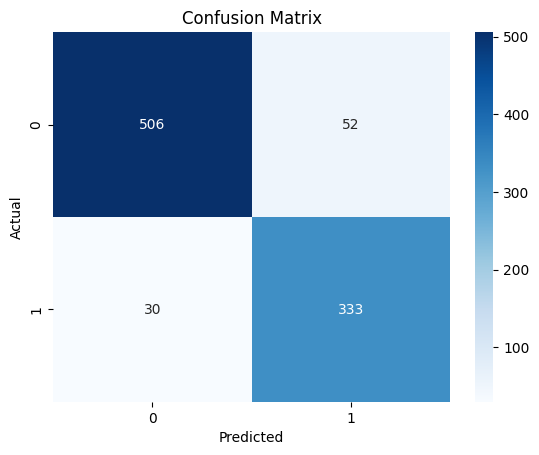

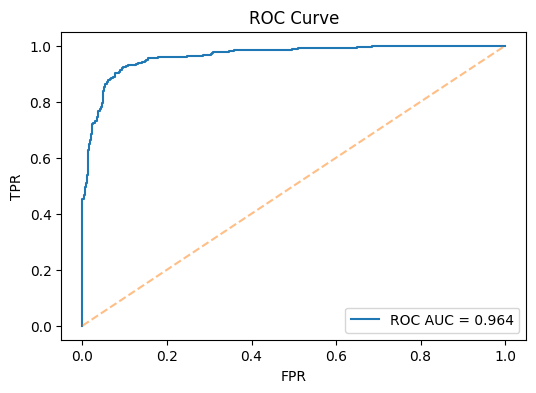

C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)



Fold 1: Accuracy: 0.9175   Precision: 0.8766   Recall: 0.9201   F1 Score: 0.8978

Fold 2: Accuracy: 0.9098   Precision: 0.8608   Recall: 0.9201   F1 Score: 0.8895

Fold 3: Accuracy: 0.9109   Precision: 0.8486   Recall: 0.9421   F1 Score: 0.8930

Fold 4: Accuracy: 0.9272   Precision: 0.8792   Recall: 0.9448   F1 Score: 0.9108

Fold 5: Accuracy: 0.9120   Precision: 0.8808   Recall: 0.8978   F1 Score: 0.8892

=== Average Metrics ===
Mean Accuracy: 0.9155 ± 0.0064
Mean Precision: 0.8692 ± 0.0125
Mean Recall:    0.9250 ± 0.0172
Mean F1 Score:  0.8961 ± 0.0080


In [8]:
# Gaussian Naive Bayes with Hyperparameter Tuning
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer, StandardScaler

pt_methods = ['yeo-johnson']
if (X_train > 0).all().all():
    pt_methods.append('box-cox')

pipeline = Pipeline([
    ('power', PowerTransformer()),   # reduce skew
    ('scaler', StandardScaler()),    # standardize
    ('clf', GaussianNB())            # classifier
])

param_grid = {
    'power__method': pt_methods,
    'clf__var_smoothing': np.logspace(-9, 0, 30)  # smaller grid for speed
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring={'AUC': 'roc_auc', 'F1': 'f1'},
    refit='AUC',
    n_jobs=-1,
    verbose=2
)

with parallel_backend('threading'):
    grid.fit(X_train, y_train)
best = grid.best_estimator_

print("\nBest parameters:", grid.best_params_)
print(f"Best CV AUC: {grid.best_score_:.4f}")

# Test the decision tree model
best_estimator = grid.best_estimator_
test_model(best_estimator, X_test, y_test)
kfoldCV(best_estimator, X, y, cv)
